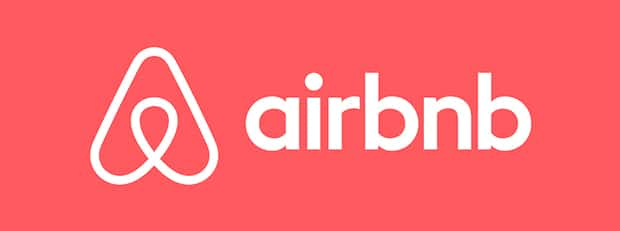
# Airbnb Analysis and Price Prediction

In [ ]:
#Installing the necessary libraries
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://bitbucket.org/habedi/datasets/raw/b6769c4664e7ff68b001e2f43bc517888cbe3642/spark/spark-3.0.2-bin-hadoop2.7.tgz
!tar xf spark-3.0.2-bin-hadoop2.7.tgz
!rm -rf spark-3.0.2-bin-hadoop2.7.tgz*
!pip -q install findspark pyspark graphframes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 18.2 MB/s eta 0:00:00


In [ ]:
#Initializing the environment
import os
os.environ["PYSPARK_DRIVER_PYTHON"] = "jupyter"
os.environ["PYSPARK_DRIVER_PYTHON_OPTS"] = "notebook"
os.environ["PYSPARK_SUBMIT_ARGS"] = "--packages graphframes:graphframes:0.8.1-spark3.0-s_2.12 pyspark-shell"

In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql.functions import col, sum as sum_, isnan, when, count, round
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.types import *

In [ ]:
from pyspark.sql import SparkSession
session= SparkSession.builder.appName("AirBnBAnalysis").getOrCreate()

In [ ]:
listing_data = session.read.csv('AB_NYC_2019.csv', header=True, inferSchema=True)

In [ ]:
listing_data.show(5)
listing_data.printSchema()

+----+--------------------+-------+-----------+-------------------+-------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+
|  id|                name|host_id|  host_name|neighbourhood_group|neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|
+----+--------------------+-------+-----------+-------------------+-------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+
|2539|Clean & quiet apt...|   2787|       John|           Brooklyn|   Kensington|40.64749|-73.97237|   Private room|  149|             1|                9| 2018-10-19|             0.21|                             6|             365|
|2595|Skylit Midtown Ca...|   2845|   Jennifer|          Manhatt

# Feature Engineering

In [ ]:
#Dropping duplicates present in the schema
airbnb = listing_data.dropDuplicates()
print(f"Total rows: {airbnb.count()}")

Total rows: 49078


In [ ]:
#Calculating the number of null values in the schema
null_counts = airbnb.select([count(when(col(c).isNull() | isnan(col(c)), c)).alias(c) for c in airbnb.columns])

null_counts.show()

+---+----+-------+---------+-------------------+-------------+--------+---------+---------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+
| id|name|host_id|host_name|neighbourhood_group|neighbourhood|latitude|longitude|room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|
+---+----+-------+---------+-------------------+-------------+--------+---------+---------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+
|  0|  31|    184|      211|                184|          184|     184|      184|      184|  184|           184|              204|      10233|            10214|                           186|             341|
+---+----+-------+---------+-------------------+-------------+--------+---------+---------+-----+--------------+-----------------+-----------+-----------------+----

In [ ]:
#Dropping 'id', 'host_name', 'last_review' columns
airbnb = airbnb.drop('id', 'host_name', 'last_review')

In [ ]:
#Dropping all the rows where there is a null value
airbnb = airbnb.na.drop()

In [ ]:
#Converting Columns from string to float where necessary for analysis
columns_to_convert = [
    'latitude', 'longitude', 'price', 'minimum_nights',
    'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count'
]

#Convert each column to float
for column_name in columns_to_convert:
    airbnb = airbnb.withColumn(column_name, col(column_name).cast('float'))

#Now, airbnb has the specified columns converted to float. Checking the updated schema to confirm.
airbnb.printSchema()
print(f"Total rows: {airbnb.count()}")

root
 |-- name: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- neighbourhood_group: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- latitude: float (nullable = true)
 |-- longitude: float (nullable = true)
 |-- room_type: string (nullable = true)
 |-- price: float (nullable = true)
 |-- minimum_nights: float (nullable = true)
 |-- number_of_reviews: float (nullable = true)
 |-- reviews_per_month: float (nullable = true)
 |-- calculated_host_listings_count: float (nullable = true)
 |-- availability_365: integer (nullable = true)

Total rows: 38701


In [ ]:
airbnb_data = airbnb

In [ ]:
#Converting the schema to a pandas dataframe for visualization
airbnb_pd = airbnb.toPandas()

In [ ]:
airbnb_pd.head()

,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Lower East Side Magic Room,314941,Manhattan,Lower East Side,40.719040,-73.993919,Private room,95.0,1.0,109.0,1.11,3.0,364
1,1BR: See Central Park from Terrace!,373085,Manhattan,Upper West Side,40.777279,-73.978180,Entire home/apt,110.0,13.0,38.0,0.39,1.0,0
2,STUDIO APT 1. IN PROSPECT LEFFERTS GARDENS,3270460,Brooklyn,Prospect-Lefferts Gardens,40.659081,-73.961250,Entire home/apt,100.0,5.0,117.0,1.61,2.0,73
3,Charming Apt. In Brooklyn Townhouse,5480570,Brooklyn,Bedford-Stuyvesant,40.683640,-73.926376,Entire home/apt,145.0,3.0,200.0,2.62,1.0,303
4,Cozy 2 BR apartment in Queens,2050338,Queens,Richmond Hill,40.694141,-73.825378,Entire home/apt,90.0,30.0,33.0,0.46,3.0,298


In [ ]:
#Removing any null values present in the dataframe
airbnb_pd.isnull().sum()
airbnb_pd.dropna(how='any',inplace=True)

In [ ]:
#Visualizing the listing on a map using folium package
import folium
from folium.plugins import MarkerCluster

# Create a map centered around an average location
nyc_map = folium.Map(location=[airbnb_pd.latitude.mean(), airbnb_pd.longitude.mean()], zoom_start=10)

# Create a marker cluster
marker_cluster = MarkerCluster().add_to(nyc_map)

# Add markers to the cluster
for idx, row in airbnb_pd.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"{row['name']}, {row['neighbourhood']}, ${row['price']}",
    ).add_to(marker_cluster)

# Display the map
nyc_map.save('nyc_map.html')


Below is the link of the screenshot of the map. To see the complete visualization please open nyc_map.html in a new window.

https://drive.google.com/file/d/13KtPHeiQtKcRNO0_oom9TBIrQGMrnQ5X/view?usp=sharing

# How can Airbnb hosts identify the most profitable locations for new listings, and how can Airbnb itself leverage this information to expand its high-revenue listing inventory and optimize pricing strategies?

In [ ]:
airbnb_data.createOrReplaceTempView("listings")

# SQL Query to find the average price per neighborhood
query = """
SELECT neighbourhood_group, neighbourhood, AVG(price) as avg_price
FROM listings
GROUP BY neighbourhood_group, neighbourhood
ORDER BY avg_price DESC
LIMIT 5
"""

# Execute the query
top_neighbourhoods = session.sql(query)

# Show the results
top_neighbourhoods.show()

+-------------------+-----------------+------------------+
|neighbourhood_group|    neighbourhood|         avg_price|
+-------------------+-----------------+------------------+
|           Brooklyn|         Sea Gate| 601.6666666666666|
|          Manhattan|          Tribeca|             460.3|
|          Manhattan|             NoHo|            301.25|
|          Manhattan|Flatiron District|291.48275862068965|
|          Manhattan|             SoHo|             281.5|
+-------------------+-----------------+------------------+



### For Hosts Considering New Listings:
1. Set Yourself Apart: In rich neighborhoods, hosts can stand out by offering unique amenities or experiences that deserve a higher charge.
2. Strategic Property Acquisition: If demand is stable, Airbnb hosts buying houses in higher-rent neighborhoods may earn more.
3. Market Penetration Tactics: By offering low pricing or great value, new entrants can gain market share in these profitable areas and develop a reputation.

### For Airbnb to Capitalize on High Revenue Opportunities:
1. Targeted Promotion: Airbnb can direct its advertising efforts to highlight properties in these lucrative neighborhoods, appealing to guests who are open to premium accommodation options.
2. Encourage New Hosts: By incentivizing property owners in these upscale neighborhoods to list on Airbnb, the platform could increase its offerings of top-tier, revenue-rich listings.
3. Pricing Strategy Tools: Offering hosts advanced pricing tools that reflect the higher average rates of these areas can assist them in maximizing their rental income.
4. Curated Local Experiences: Airbnb could create bespoke local experiences in these high-value neighborhoods to augment guests' stays and support premium pricing strategies.

In [ ]:
airbnb_data.printSchema()
print(f"Total rows: {airbnb_data.count()}")

root
 |-- name: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- neighbourhood_group: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- latitude: float (nullable = true)
 |-- longitude: float (nullable = true)
 |-- room_type: string (nullable = true)
 |-- price: float (nullable = true)
 |-- minimum_nights: float (nullable = true)
 |-- number_of_reviews: float (nullable = true)
 |-- reviews_per_month: float (nullable = true)
 |-- calculated_host_listings_count: float (nullable = true)
 |-- availability_365: integer (nullable = true)

Total rows: 38701


In [ ]:
#Checking if any null values are present in the schema, if yes, dropping the rows with the null values
null_counts = airbnb_data.select([count(when(col(c).isNull() | isnan(col(c)), c)).alias(c) for c in airbnb.columns])

null_counts.show()

airbnb_data = airbnb_data.na.drop()

null_counts = airbnb_data.select([count(when(col(c).isNull() | isnan(col(c)), c)).alias(c) for c in airbnb.columns])

null_counts.show()

+----+-------+-------------------+-------------+--------+---------+---------+-----+--------------+-----------------+-----------------+------------------------------+----------------+
|name|host_id|neighbourhood_group|neighbourhood|latitude|longitude|room_type|price|minimum_nights|number_of_reviews|reviews_per_month|calculated_host_listings_count|availability_365|
+----+-------+-------------------+-------------+--------+---------+---------+-----+--------------+-----------------+-----------------+------------------------------+----------------+
|   0|      0|                  0|            0|       7|        1|        0|    6|             2|                0|                6|                             1|               0|
+----+-------+-------------------+-------------+--------+---------+---------+-----+--------------+-----------------+-----------------+------------------------------+----------------+

+----+-------+-------------------+-------------+--------+---------+---------+-----+-

In [ ]:
#Dropping 'name','host_id','availability_365','latitude','longitude' columns as they are not useful features for the prediction model
airbnb_data.drop('name','host_id','availability_365','latitude','longitude')

DataFrame[neighbourhood_group: string, neighbourhood: string, room_type: string, price: float, minimum_nights: float, number_of_reviews: float, reviews_per_month: float, calculated_host_listings_count: float]

## Feature engineering for categorical variables

In [ ]:
from pyspark.ml.feature import StringIndexer
str_obj=StringIndexer(inputCols=["neighbourhood_group","neighbourhood","room_type"],outputCols=["new_neighbourhood_group","new_neighbourhood","new_room_type"], handleInvalid="keep")

In [ ]:
from pyspark.ml.feature import OneHotEncoder
onehot_obj=OneHotEncoder(inputCols=["new_neighbourhood_group","new_neighbourhood","new_room_type"],outputCols=["new_neighbourhood_group_2","new_neighbourhood2","new_room_type2"])

In [ ]:
from  pyspark.ml.feature import VectorAssembler
vec_obj=VectorAssembler(inputCols=["new_neighbourhood_group_2","new_neighbourhood2","new_room_type2","minimum_nights","number_of_reviews","reviews_per_month","calculated_host_listings_count"], outputCol="all_features")

The feature engineering performed on the Airbnb dataset plays a crucial role in enhancing its suitability for predictive analysis:

1. **Duplicate Removal**: Ensures data uniqueness, eliminating overrepresentation and maintaining statistical integrity.
2. **Null Handling**: Improves data quality by removing incomplete records, ensuring analyses and predictions are based on reliable data.
3. **Feature Reduction**: Discards irrelevant features ('id', 'host_name', 'last_review'), focusing the model on impactful variables for price prediction.
4. **Data Standardization**: Converts key metrics to float, facilitating accurate numerical operations and analyses.
5. **Categorical Encoding**: Transforms qualitative data into machine-readable formats through string indexing and one-hot encoding, enabling the inclusion of categorical variables like 'neighbourhood' and 'room_type' in the predictive model.
6. **Feature Vectorization**: Aggregates relevant features into a single vector, simplifying model inputs and enabling simultaneous feature consideration.

These steps not only clean and simplify the dataset but also enrich it with structured, meaningful features, setting the stage for accurate and insightful price prediction models for Airbnb listings.

#How can a predictive pricing model utilize neighborhood trends, room type, minimum night requirements, and existing listing counts to recommend a competitive yet profitable price range for new Airbnb hosts?

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

def categorize_price(price):
    if price < 100:
        return 0  # Low Price
    elif price < 200:
        return 1  # Medium Price
    else:
        return 2  # High Price

# Register UDF
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

categorize_price_udf = udf(categorize_price, IntegerType())
data = airbnb_data.withColumn("price_category", categorize_price_udf("price"))


indexer = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(data)
           for column in ["neighbourhood_group", "neighbourhood", "room_type"]]
encoder = [OneHotEncoder(inputCols=[column+"_index"], outputCols=[column+"_vec"])
           for column in ["neighbourhood_group", "neighbourhood", "room_type"]]
assembler = VectorAssembler(inputCols=["neighbourhood_group_vec", "neighbourhood_vec", "room_type_vec",
                                        "minimum_nights", "number_of_reviews",
                                        "reviews_per_month", "calculated_host_listings_count"],
                            outputCol="features")

# Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol="price_category")

# Pipeline
pipeline = Pipeline(stages=indexer + encoder + [assembler, lr])

# Split the data
(trainData, testData) = data.randomSplit([0.7, 0.3])

# Train the model
model = pipeline.fit(trainData)

# Make predictions
predictions = model.transform(testData)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="price_category", predictionCol="prediction",
                                              metricName="accuracy")

# Calculate accuracy
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %g" % accuracy)

Accuracy = 0.687146


The inference from the logistic regression model with an accuracy of 65-70% is that while the model has some predictive power, there is room for improvement. The model is moderately successful in categorizing Airbnb listings into low, medium, and high price ranges based on neighborhood trends, room type, minimum night requirements, and the count of existing listings.

Given the complexity of pricing in the real estate and rental market, this level of accuracy indicates that while the model captures some of the patterns in the data, other factors not included in the model may also be influencing listing prices. It may benefit from additional data, more nuanced feature engineering, or possibly a different modeling approach to increase its predictive accuracy.

For a potential Airbnb host, this model provides a starting point for understanding how various factors might influence the pricing category of their listing, but it should be supplemented with market research and perhaps personal judgment or consultation with Airbnb market experts.

In [ ]:
from graphframes import *
from pyspark import *

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import Imputer

session=SparkSession.builder.appName("machinelearninginspark").master("local").getOrCreate()


In [ ]:
from pyspark.sql import *

spark = SparkSession.builder.appName('myfunction').getOrCreate()

vertices = spark.read.option('header', 'true').csv('vertices_final_1.csv')
edges = spark.read.option('header', 'true').csv('edges_final_1.csv')

# Create a GraphFrame
g = GraphFrame(vertices, edges)

# Running PageRank algorithm to identify the most influential host or neighborhood
results = g.pageRank(resetProbability=0.15, maxIter=10)

# Display the results sorted by pagerank in descending order
results.vertices.orderBy("pagerank", ascending=False).show()

+---+--------------------+------------------+
| id|              entity|          pagerank|
+---+--------------------+------------------+
| 44|        East Village|1.9742690058479528|
| 31|  Bedford-Stuyvesant|1.9643274853801165|
| 41|          Park Slope|1.7356725146198826|
| 27|              Harlem|1.6959064327485376|
| 45|          Greenpoint|1.6859649122807014|
| 32|      Hell's Kitchen|1.5368421052631576|
| 47|            Flatbush|1.4970760233918126|
| 39|             Chelsea| 1.437426900584795|
| 25|          Kensington|1.4175438596491223|
| 37|        Williamsburg| 1.387719298245614|
| 40|       Crown Heights|1.3181286549707598|
| 49|Prospect-Lefferts...|1.2684210526315784|
| 43|              Inwood|1.2385964912280698|
| 46|            Bushwick|1.2087719298245612|
| 48|     Lower East Side|1.1192982456140348|
| 29|         East Harlem|1.0994152046783623|
| 35|         South Slope| 1.049707602339181|
| 38|         Fort Greene| 1.049707602339181|
| 42|     Windsor Terrace| 1.01988

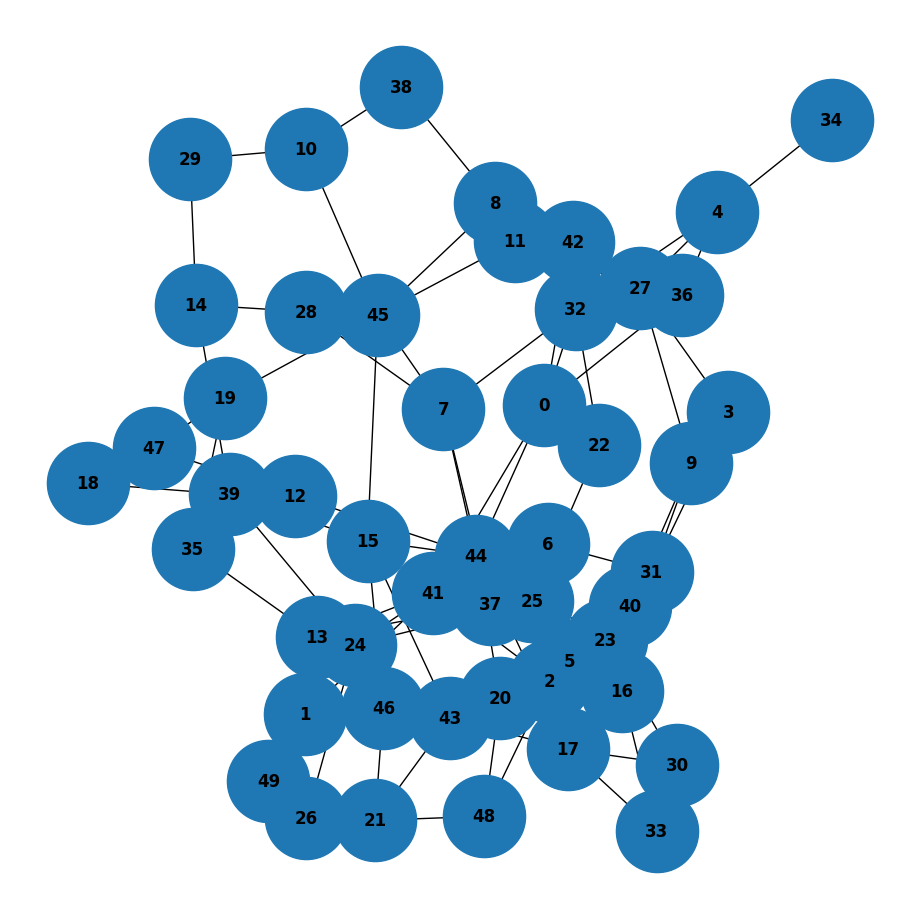

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
# the function will plot the source and destination nodes and connect them by meand of undirected line
def plot_undirected_graph(edge_list):
    plt.figure(figsize=(9,9))
    gplot=nx.Graph()
    for row in edge_list.select("src", "dst").take(1000):
        gplot.add_edge(row["src"], row["dst"])
    nx.draw(gplot, with_labels=True, font_weight="bold", node_size=3500)
plot_undirected_graph(g.edges)


**Key Insights from Page Rank and Graph Airbnb Market Analysis:**

1. **Neighborhood Popularity**: "East Village" and "Bedford-Stuyvesant" are identified as popular hubs in the Airbnb network, suggesting they are highly sought after by guests.

2. **Host Significance**: Certain hosts appear as central figures, indicating their strong presence and influence on the platform.

3. **Growth Potential**: Peripheral areas present opportunities for expansion and diversification of listings.

4. **Strategic Marketing**: Centrally positioned neighborhoods and hosts could be leveraged in targeted marketing campaigns to maximize visibility.

In essence, the analysis pinpoints strategic areas for investment and partnership, guiding efforts to optimize market presence and enhance user experiences on Airbnb.
